In [57]:
#Imports
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb


DATA_DIR = Path("/Users/jordanholzer/Documents/Personal/Neighbor Project/neighbornextsteps")
DATA_DIR.mkdir(parents=True, exist_ok=True)


EXPLICIT_TABLE_MAP = {

}

#Helpers in case we need them
def slugify(name: str) -> str:
    """Make a safe SQL table name: lowercase, alnum + underscores; no leading digits."""
    base = re.sub(r"[^\w]+", "_", name.strip().lower()).strip("_")
    if re.match(r"^\d", base):
        base = f"t_{base}"
    return base

def detect_date_cols(columns):
    """Heuristic: columns with 'date' or 'time' in the name are parsed as dates."""
    return [c for c in columns if re.search(r"(date|time|timestamp)", c, re.I)]

def read_csv_safely(path: Path) -> pd.DataFrame:

    sample = pd.read_csv(path, nrows=50)
    date_cols = detect_date_cols(sample.columns)

    read_kwargs = {
        "dtype_backend": "pyarrow",
        "low_memory": False,
    }
    try:
        df = pd.read_csv(path, parse_dates=date_cols, engine="pyarrow", **read_kwargs)
    except Exception:
        df = pd.read_csv(path, parse_dates=date_cols, **{k: v for k, v in read_kwargs.items() if k != "dtype_backend"})
    return df

def preview_df(df: pd.DataFrame, name: str, n: int = 5):
    print(f"\n=== {name} ({len(df):,} rows x {df.shape[1]} cols) ===")
    display(df.head(n))

csv_paths = []
if EXPLICIT_TABLE_MAP:
    for fname in EXPLICIT_TABLE_MAP.keys():
        p = DATA_DIR / fname
        if not p.exists():
            raise FileNotFoundError(f"Expected file not found: {p}")
        csv_paths.append(p)
else:
    csv_paths = sorted(DATA_DIR.glob("*.csv"))
    if not csv_paths:
        raise FileNotFoundError(f"No CSV files found in {DATA_DIR.resolve()}")

dfs = {}

for p in csv_paths:
    table_name = EXPLICIT_TABLE_MAP.get(p.name, slugify(p.stem))
    df = read_csv_safely(p)
    df.columns = [c.strip() for c in df.columns]
    dfs[table_name] = df
    preview_df(df, table_name)

print("\nTables loaded:", ", ".join(dfs.keys()))

con = duckdb.connect(database=":memory:")

for name, df in dfs.items():
    con.register(name, df)


def sql(query: str) -> pd.DataFrame:
    """Run a SQL query against the registered tables and return a pandas DataFrame."""
    return con.sql(query).df()


Matplotlib is building the font cache; this may take a moment.



=== all_search_events_1 (100,000 rows x 34 cols) ===


,event_uuid,event_type,merged_amplitude_id,ip_address,search_id,search_type,search_term,prior_search_id,latitude,longitude,...,hex_6_resolution,hex_7_resolution,hex_8_resolution,hex_9_resolution,search_dma,first_attribution_source,first_attribution_channel,event_time,event_date,month
0,63571708-f020-4177-9087-56c8405bdc12,search,9155,129.153.198.180,4d5382d7-be85-4ccd-9b31-4d41b5f5fb29,map,condo,NaN,45.627190,-85.835552,...,2e09edf2ccbd,2e09edf2ccbd6c,2e09edf2ccbd6c53,2e09edf2ccbd6c5352,Atlanta,paid,facebook,2023-07-22 14:24:39,2023-07-22,7
1,0d18d995-610f-4248-8442-c0d03656aa90,search,9580,183.214.39.114,53cbff32-1e13-42c5-9c81-d971807a0af2,location,condo,NaN,29.376661,-90.486101,...,0d05763fa28b,0d05763fa28b37,0d05763fa28b375a,0d05763fa28b375a0d,Boston,organic,google,2023-01-24 04:15:43,2023-01-24,1
2,e9deb214-0938-4c09-9183-85e2bf7b1f21,search,1069,113.163.209.250,3c486c99-99e7-4ed5-bbcd-a31e9f2fb720,map,desert retreat,NaN,40.836230,-88.721003,...,f7577ac3ef17,f7577ac3ef1731,f7577ac3ef173175,f7577ac3ef173175d6,New York,organic,google,2023-03-12 06:19:31,2023-03-12,3
3,aa6f7ea8-cad4-48f7-a0ac-d7c42fd3a873,search,6787,133.144.103.224,922aa3a2-50e2-4538-89aa-fbdba8fb15c9,filter,ski chalet,NaN,34.336097,-70.109675,...,660b69c89488,660b69c894885f,660b69c894885fa5,660b69c894885fa5e3,Houston,organic,google maps,2023-12-20 10:08:57,2023-12-20,12
4,1487c605-20bc-4593-bd7f-9d25660b26cb,search,6577,130.8.186.60,1c2baf98-1af0-41c7-ab9c-13abd440cb41,map,apartment,NaN,34.440344,-107.939240,...,d75f5b159b15,d75f5b159b1555,d75f5b159b15557e,d75f5b159b15557e2f,Chicago,paid,reddit,2023-01-16 00:45:53,2023-01-16,1



=== amplitude_user_ids_1 (10,000 rows x 3 cols) ===


,amplitude_id,merged_amplitude_id,user_id
0,1,1,1.0
1,2,2,2.0
2,3,3,3.0
3,4,4,4.0
4,5,5,5.0



=== reservations_1 (10,363 rows x 9 cols) ===


,reservation_id,renter_user_id,host_user_id,listing_id,created_at,approved_at,successful_payment_collected_at,hex_08_id,dma
0,1,8650,378,660,2023-01-02 08:34:49.186386,2023-01-02 17:19:39.922525,2023-01-02 17:41:33.048903,e4bf25491e508c73,San Francisco
1,2,5900,302,96,2023-09-10 15:00:10.232206,2023-09-10 19:22:20.955217,2023-09-10 19:38:41.528126,3224fe7cbf365637,Boston
2,3,6061,42,257,2023-06-30 05:36:38.181631,2023-06-30 17:12:53.436124,2023-06-30 17:29:37.778263,4d4c926065e95e0d,Philadelphia
3,4,5735,476,194,2023-12-23 17:00:42.381330,2023-12-24 06:31:43.785891,2023-12-24 06:57:17.531035,b68c679502560d4a,Boston
4,5,541,463,34,2023-08-21 18:50:26.272940,2023-08-22 00:03:18.431382,2023-08-22 00:21:22.019442,5da16cacc1b75adb,Washington DC



=== view_listing_detail_events_1 (88,633 rows x 28 cols) ===


,event_uuid,event_type,merged_amplitude_id,ip_address,listing_id,latitude,longitude,is_bot,is_host,is_listing_reserved,...,hex_6_resolution,hex_7_resolution,hex_8_resolution,hex_9_resolution,click_dma,first_attribution_source,first_attribution_channel,event_time,event_date,month
0,5f025add-3ee2-42fe-8aed-56486ac55cdb,view_listing_detail,9155,129.153.198.180,354,45.636506,-85.833613,False,False,False,...,2e09edf2ccbd,2e09edf2ccbd6c,2e09edf2ccbd6c53,2e09edf2ccbd6c5352,Atlanta,paid,facebook,2023-07-22 14:27:34.268237,2023-07-22,7
1,3e1cd3ae-0413-4ace-aa1b-ef7ae57a43f0,view_listing_detail,9155,129.153.198.180,954,45.632481,-85.840004,False,False,False,...,2e09edf2ccbd,2e09edf2ccbd6c,2e09edf2ccbd6c53,2e09edf2ccbd6c5352,Atlanta,paid,facebook,2023-07-22 14:26:24.414888,2023-07-22,7
2,cf2cdbf8-5ae5-47ed-baf9-116403bf7185,view_listing_detail,9155,129.153.198.180,936,45.626113,-85.841419,False,False,False,...,2e09edf2ccbd,2e09edf2ccbd6c,2e09edf2ccbd6c53,2e09edf2ccbd6c5352,Atlanta,paid,facebook,2023-07-22 14:26:22.963925,2023-07-22,7
3,d0602eda-573b-4a6e-976f-6e061f1107cd,view_listing_detail,9155,129.153.198.180,8,45.619123,-85.842365,False,False,False,...,2e09edf2ccbd,2e09edf2ccbd6c,2e09edf2ccbd6c53,2e09edf2ccbd6c5352,Atlanta,paid,facebook,2023-07-22 14:26:34.844490,2023-07-22,7
4,d832ef60-35dd-458f-8cdd-ae19c5702c28,view_listing_detail,9155,129.153.198.180,296,45.630233,-85.839205,False,False,False,...,2e09edf2ccbd,2e09edf2ccbd6c,2e09edf2ccbd6c53,2e09edf2ccbd6c5352,Atlanta,paid,facebook,2023-07-22 14:24:43.819036,2023-07-22,7



Tables loaded: all_search_events_1, amplitude_user_ids_1, reservations_1, view_listing_detail_events_1

✅ You can now query with SQL. Registered tables:
                           name
0           all_search_events_1
1          amplitude_user_ids_1
2                reservations_1
3  view_listing_detail_events_1


In [39]:
evt_df = sql("""
    SELECT is_host, COUNT(*)
    FROM view_listing_detail_events_1
    GROUP BY 1
    ORDER BY 2 DESC
""")
display(evt_df)

,is_host,count_star()
0,False,79738
1,True,8895


In [12]:
counting_df = sql("""
    SELECT a.user_id, COUNT(search.event_uuid)
    FROM all_search_events_1 as search
    INNER JOIN amplitude_user_ids_1 as a on a.merged_amplitude_id = search.merged_amplitude_id
    GROUP BY 1
    ORDER BY 2 DESC
""")
display(counting_df)

,user_id,"count(""search"".event_uuid)"
0,NaN,12182
1,40.0,26
2,6009.0,26
3,1246.0,26
4,2708.0,26
...,...,...
9025,5910.0,3
9026,7543.0,3
9027,6378.0,2
9028,7230.0,2


In [22]:
nullusers_df = sql("""
    SELECT user_id
    FROM amplitude_user_ids_1
    WHERE user_id is NULL
    ORDER BY 1
""")
display(nullusers_df)

,user_id
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
966,NaN
967,NaN
968,NaN
969,NaN


In [41]:
firstbucket_df = sql("""
    SELECT first_attribution_source, first_attribution_channel, COUNT(DISTINCT a1.user_id)
    FROM all_search_events_1 as as1
    INNER JOIN amplitude_user_ids_1 as a1 on a1.merged_amplitude_id = as1.merged_amplitude_id
    GROUP BY 1, 2
    ORDER BY 3 DESC
""")
display(firstbucket_df)

secondbucket_df = sql("""
    SELECT first_attribution_source, first_attribution_channel, COUNT(DISTINCT a1.user_id)
    FROM view_listing_detail_events_1 as vl1
    INNER JOIN amplitude_user_ids_1 as a1 on a1.merged_amplitude_id = vl1.merged_amplitude_id
    GROUP BY 1, 2
    ORDER BY 3 DESC
""")
display(secondbucket_df)

,first_attribution_source,first_attribution_channel,count(DISTINCT a1.user_id)
0,paid,google ads,8912
1,direct,direct,8661
2,organic,google,8157
3,paid,facebook,6511
4,organic,google maps,5153
5,paid,reddit,4198


,first_attribution_source,first_attribution_channel,count(DISTINCT a1.user_id)
0,paid,google ads,4395
1,direct,direct,4298
2,organic,google,4040
3,paid,facebook,3236
4,organic,google maps,2573
5,paid,reddit,2075


In [31]:
thirdbucket_df = sql("""
    SELECT COUNT(reservation_id)
    FROM reservations_1
""")
display(thirdbucket_df)

,count(reservation_id)
0,10363


In [42]:
user_reserved_bucket_df = sql("""
    SELECT COUNT(DISTINCT user_id)
    FROM reservations_1 as r1
    INNER JOIN amplitude_user_ids_1 as a1 on a1.user_id = r1.renter_user_id
""")
display(user_reserved_bucket_df)

,count(DISTINCT user_id)
0,1463


In [48]:
funnel_df = sql("""
WITH first_users AS (
  SELECT DISTINCT a1.user_id, a1.merged_amplitude_id
  FROM amplitude_user_ids_1 a1
  JOIN all_search_events_1 as1
    ON a1.merged_amplitude_id = as1.merged_amplitude_id
  WHERE a1.user_id IS NOT NULL
),
second_users AS (
  SELECT DISTINCT a2.user_id
  FROM view_listing_detail_events_1 vl1
  JOIN first_users a2
    ON a2.merged_amplitude_id = vl1.merged_amplitude_id
),
third_users AS (
  SELECT DISTINCT r1.renter_user_id AS user_id
  FROM reservations_1 r1
  JOIN second_users a3
    ON a3.user_id = r1.renter_user_id
),
counts AS (
  SELECT
    (SELECT COUNT(DISTINCT user_id) FROM first_users ) AS search_users,
    (SELECT COUNT(DISTINCT user_id) FROM second_users) AS view_users,
    (SELECT COUNT(DISTINCT user_id) FROM third_users ) AS reserve_users
)
SELECT
  stage,
  users,
  ROUND(100.0 * users / NULLIF(prev_users, 0), 2)       AS step_conversion_pct,     -- from previous stage
  ROUND(100.0 * users / NULLIF(counts.search_users, 0), 2)     AS cumulative_from_search_pct
FROM counts,
LATERAL (
  VALUES
    ('search' , search_users , NULL       , search_users),
    ('view'   , view_users   , search_users, search_users),
    ('reserve', reserve_users, view_users , search_users)
) AS stages(stage, users, prev_users, search_users)
""")

display(funnel_df)

,stage,users,step_conversion_pct,cumulative_from_search_pct
0,search,9029,NaN,100.00
1,view,4467,49.47,49.47
2,reserve,1463,32.75,16.20


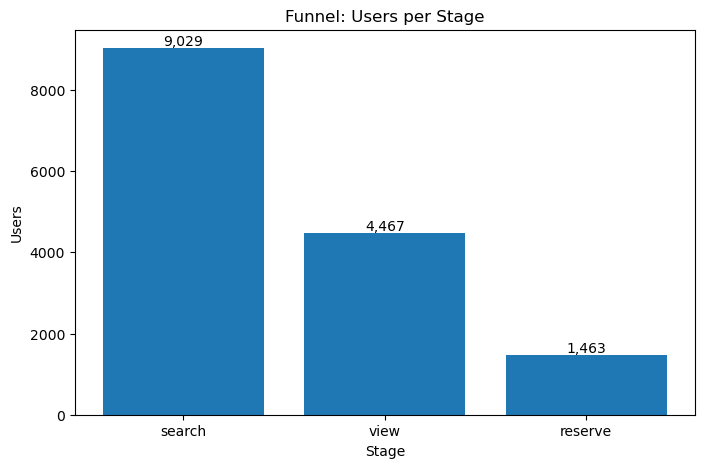

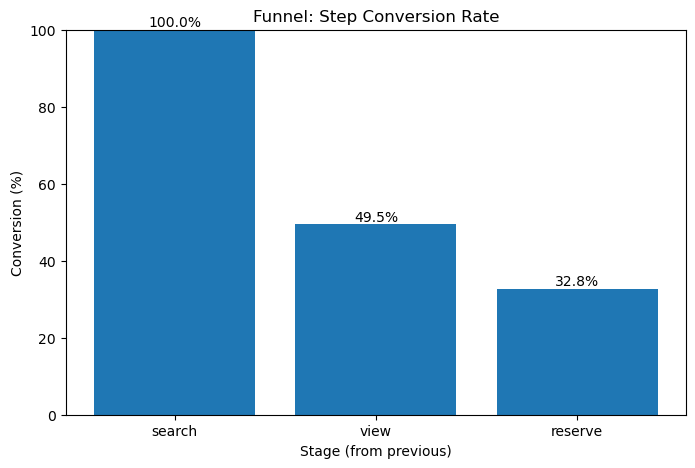

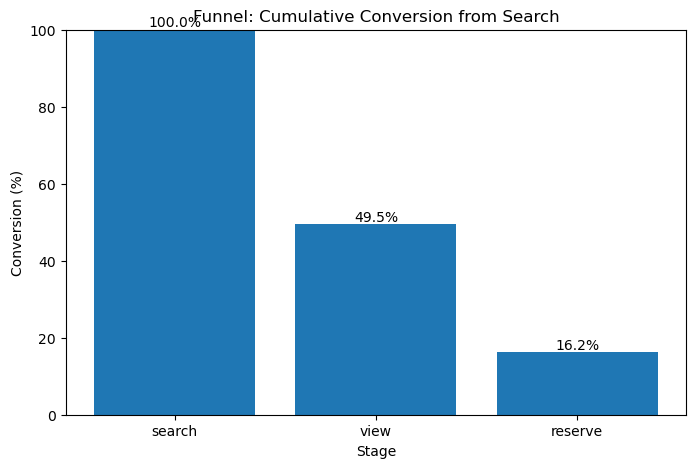

In [58]:
stage_order = ["search", "view", "reserve"]
fdf = funnel_df.copy()
fdf["stage"] = pd.Categorical(fdf["stage"].str.lower(), categories=stage_order, ordered=True)
fdf = fdf.sort_values("stage")

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(fdf["stage"], fdf["users"])
ax.set_title("Funnel: Users per Stage")
ax.set_xlabel("Stage")
ax.set_ylabel("Users")

for bar, val in zip(bars, fdf["users"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{int(val):,}", ha="center", va="bottom")
plt.show()

step_pct = fdf["step_conversion_pct"].fillna(100.0)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(fdf["stage"], step_pct)
ax.set_title("Funnel: Step Conversion Rate")
ax.set_xlabel("Stage (from previous)")
ax.set_ylabel("Conversion (%)")
ax.set_ylim(0, 100)

for bar, val in zip(bars, step_pct):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{val:.1f}%", ha="center", va="bottom")
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(fdf["stage"], fdf["cumulative_from_search_pct"])
ax.set_title("Funnel: Cumulative Conversion from Search")
ax.set_xlabel("Stage")
ax.set_ylabel("Conversion (%)")
ax.set_ylim(0, 100)

for bar, val in zip(bars, fdf["cumulative_from_search_pct"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{val:.1f}%", ha="center", va="bottom")
plt.show()

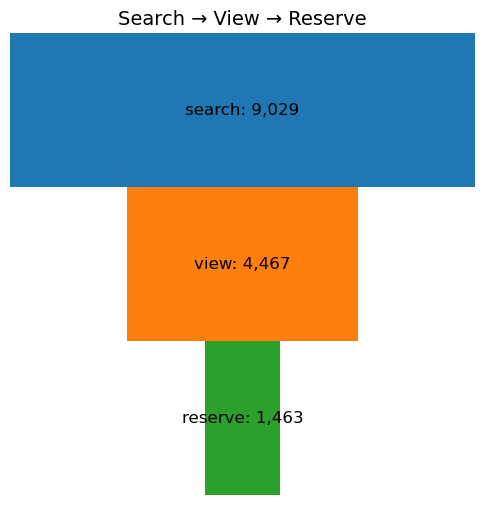

In [64]:
def plot_funnel_area_topdown(funnel_df, title="Conversion Funnel"):
    order = ["search", "view", "reserve"]
    fdf = funnel_df.copy()
    fdf["stage"] = fdf["stage"].str.lower()
    fdf = (fdf.set_index("stage")
              .reindex(order)
              .reset_index())
    
    n = len(fdf)
    max_users = fdf["users"].max()

    fig, ax = plt.subplots(figsize=(6, 6))

    for i, row in enumerate(fdf.itertuples(index=False)):
        stage = row.stage
        u = row.users
        width = (u / max_users) if max_users else 0.0

        y0 = n - i - 1
        y1 = n - i
        left = 0.5 - width / 2
        right = 0.5 + width / 2

        ax.fill_betweenx([y0, y1], left, right)
        ax.text(0.5, (y0 + y1) / 2, f"{stage}: {u:,}", ha="center", va="center", fontsize=12)

    ax.set_ylim(0, n)
    ax.set_xlim(0, 1)
    ax.axis("off")
    ax.set_title(title, fontsize=14)
    plt.show()

plot_funnel_area_topdown(funnel_df, title="Search → View → Reserve")

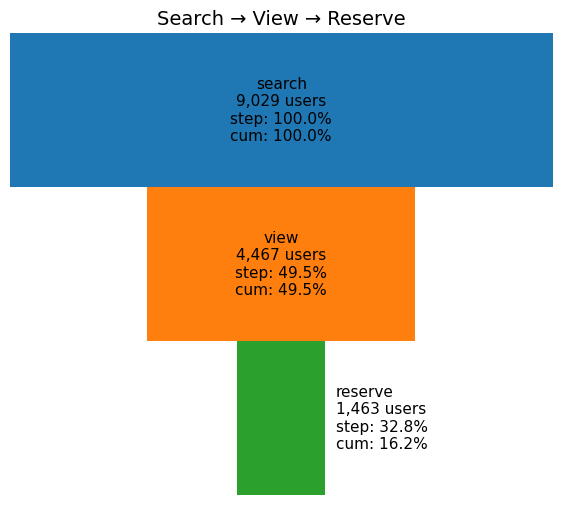

In [65]:
def plot_funnel_area_topdown_with_pcts(
    funnel_df: pd.DataFrame,
    title: str = "Conversion Funnel",
    stage_order = ("search", "view", "reserve"),
    show_counts: bool = True,
    pct_label: str = "both"  # "step", "cumulative", or "both"
):

    fdf = funnel_df.copy()
    fdf["stage"] = fdf["stage"].str.lower()
    fdf = (fdf.set_index("stage")
               .reindex(stage_order)
               .reset_index())

    #take care of missing values if we need
    if "step_conversion_pct" not in fdf.columns:
        fdf["step_conversion_pct"] = np.nan
    if "cumulative_from_search_pct" not in fdf.columns:
        fdf["cumulative_from_search_pct"] = np.nan

    #only show for the other areas, not the first
    if pd.isna(fdf.loc[0, "step_conversion_pct"]):
        fdf.loc[0, "step_conversion_pct"] = 100.0

    max_users = float(fdf["users"].max()) if len(fdf) else 0.0
    n = len(fdf)

    fig, ax = plt.subplots(figsize=(7, 6))

    for i, row in enumerate(fdf.itertuples(index=False)):
        stage = row.stage
        users = float(row.users)
        step_pct = float(row.step_conversion_pct) if not pd.isna(row.step_conversion_pct) else np.nan
        cum_pct  = float(row.cumulative_from_search_pct) if not pd.isna(row.cumulative_from_search_pct) else np.nan

        y0 = n - i - 1
        y1 = n - i
        width = (users / max_users) if max_users else 0.0
        left  = 0.5 - width / 2
        right = 0.5 + width / 2

        ax.fill_betweenx([y0, y1], left, right)

        #labels
        label_lines = [stage]
        if show_counts:
            label_lines.append(f"{int(users):,} users")
        if pct_label in ("step", "both"):
            label_lines.append(f"step: {step_pct:.1f}%")
        if pct_label in ("cumulative", "both"):
            label_lines.append(f"cum: {cum_pct:.1f}%")

        #readability on the chart if we need
        x_text = 0.5
        if width < 0.18:
            x_text = min(right + 0.02, 0.98)

        ax.text(x_text, (y0 + y1) / 2,
                "\n".join(label_lines),
                ha="center" if x_text == 0.5 else "left",
                va="center", fontsize=11)

    ax.set_ylim(0, n)
    ax.set_xlim(0, 1)
    ax.axis("off")
    ax.set_title(title, fontsize=14)
    plt.show()

plot_funnel_area_topdown_with_pcts(
    funnel_df,
    title="Search → View → Reserve",
    pct_label="both"
)

In [49]:
funnel_by_src_channel = sql("""
WITH search_rows AS (
  SELECT
    a1.user_id,
    a1.merged_amplitude_id,
    as1.first_attribution_source  AS src_s,
    as1.first_attribution_channel AS ch_s,
    as1.event_date                AS ts_s
  FROM amplitude_user_ids_1 a1
  JOIN all_search_events_1 as1
    ON a1.merged_amplitude_id = as1.merged_amplitude_id
  WHERE a1.user_id IS NOT NULL
),
searchers AS (
  SELECT
    user_id,
    merged_amplitude_id,
    COALESCE( ARG_MIN(src_s, ts_s), 'unknown') AS attr_source,
    COALESCE( ARG_MIN(ch_s , ts_s), 'unknown') AS attr_channel
  FROM search_rows
  GROUP BY 1,2
),

viewers AS (
  SELECT DISTINCT
    s.user_id,
    s.attr_source,
    s.attr_channel
  FROM view_listing_detail_events_1 vl1
  JOIN searchers s
    ON s.merged_amplitude_id = vl1.merged_amplitude_id
),

reservers AS (
  SELECT DISTINCT
    r1.renter_user_id AS user_id,
    v.attr_source,
    v.attr_channel
  FROM reservations_1 r1
  JOIN viewers v
    ON v.user_id = r1.renter_user_id
),

counts AS (
  SELECT
    attr_source,
    attr_channel,
    COUNT(DISTINCT user_id) FILTER (WHERE stage = 'search')  AS search_users,
    COUNT(DISTINCT user_id) FILTER (WHERE stage = 'view')    AS view_users,
    COUNT(DISTINCT user_id) FILTER (WHERE stage = 'reserve') AS reserve_users
  FROM (
    SELECT attr_source, attr_channel, user_id, 'search'  AS stage FROM searchers
    UNION ALL
    SELECT attr_source, attr_channel, user_id, 'view'    AS stage FROM viewers
    UNION ALL
    SELECT attr_source, attr_channel, user_id, 'reserve' AS stage FROM reservers
  )
  GROUP BY 1,2
)

SELECT
  attr_source  AS first_attribution_source,
  attr_channel AS first_attribution_channel,
  search_users,
  view_users,
  reserve_users,
  ROUND(100.0 * view_users    / NULLIF(search_users, 0), 2) AS search_to_view_pct,
  ROUND(100.0 * reserve_users / NULLIF(view_users, 0), 2)   AS view_to_reserve_pct,
  ROUND(100.0 * reserve_users / NULLIF(search_users, 0), 2) AS search_to_reserve_pct
FROM counts
ORDER BY reserve_users DESC NULLS LAST, search_to_reserve_pct DESC NULLS LAST
""")

display(funnel_by_src_channel)

,first_attribution_source,first_attribution_channel,search_users,view_users,reserve_users,search_to_view_pct,view_to_reserve_pct,search_to_reserve_pct
0,paid,google ads,3114,1508,505,48.43,33.49,16.22
1,direct,direct,2232,1151,376,51.57,32.67,16.85
2,organic,google,1818,906,302,49.83,33.33,16.61
3,paid,facebook,903,431,135,47.73,31.32,14.95
4,paid,reddit,471,225,76,47.77,33.78,16.14
5,organic,google maps,491,246,69,50.10,28.05,14.05


In [72]:
SEARCH_TS_EXPR = "as1.event_time"
VIEW_TS_EXPR   = "vl1.event_time"
RES_TS_EXPR    = "r1.created_at"

funnel_by_search_type = sql(f"""
WITH search_rows AS (
  SELECT
    a1.user_id,
    a1.merged_amplitude_id,
    COALESCE(LOWER(as1.search_type), 'unknown') AS search_type,
    CAST({SEARCH_TS_EXPR} AS TIMESTAMP)         AS t_search
  FROM amplitude_user_ids_1 a1
  JOIN all_search_events_1 as1
    ON a1.merged_amplitude_id = as1.merged_amplitude_id
  WHERE a1.user_id IS NOT NULL
),
first_touch AS (
 --take the first for each user
  SELECT
    user_id,
    merged_amplitude_id,
    ARG_MIN(search_type, t_search) AS search_type,
    MIN(t_search)                  AS t0
  FROM search_rows
  GROUP BY 1,2
),
viewers AS (
  -- when users view things after the first
  SELECT DISTINCT
    s.user_id,
    s.search_type
  FROM view_listing_detail_events_1 vl1
  JOIN first_touch s
    ON s.merged_amplitude_id = vl1.merged_amplitude_id
   AND CAST({VIEW_TS_EXPR} AS TIMESTAMP) >= s.t0
),
reservers AS (
  --users make reservations
  SELECT DISTINCT
    r1.renter_user_id AS user_id,
    s.search_type
  FROM reservations_1 r1
  JOIN first_touch s
    ON s.user_id = r1.renter_user_id
  WHERE CAST({RES_TS_EXPR} AS TIMESTAMP) >= s.t0
),
counts AS (
  SELECT
    search_type,
    COUNT(DISTINCT user_id) FILTER (WHERE stage='search')  AS search_users,
    COUNT(DISTINCT user_id) FILTER (WHERE stage='view')    AS view_users,
    COUNT(DISTINCT user_id) FILTER (WHERE stage='reserve') AS reserve_users
  FROM (
    SELECT search_type, user_id, 'search'  AS stage FROM first_touch
    UNION ALL
    SELECT search_type, user_id, 'view'    AS stage FROM viewers
    UNION ALL
    SELECT search_type, user_id, 'reserve' AS stage FROM reservers
  )
  GROUP BY search_type
)
SELECT
  search_type,
  search_users,
  view_users,
  reserve_users,
  ROUND(100.0 * view_users    / NULLIF(search_users, 0), 2) AS search_to_view_pct,
  ROUND(100.0 * reserve_users / NULLIF(view_users, 0), 2)   AS view_to_reserve_pct,
  ROUND(100.0 * reserve_users / NULLIF(search_users, 0), 2) AS search_to_reserve_pct
FROM counts
ORDER BY reserve_users DESC NULLS LAST, search_to_reserve_pct DESC NULLS LAST
""")

display(funnel_by_search_type)

,search_type,search_users,view_users,reserve_users,search_to_view_pct,view_to_reserve_pct,search_to_reserve_pct
0,direct,2279,1121,375,49.19,33.45,16.45
1,location,2287,1145,365,50.07,31.88,15.96
2,map,2276,1166,362,51.23,31.05,15.91
3,filter,2187,1035,361,47.33,34.88,16.51


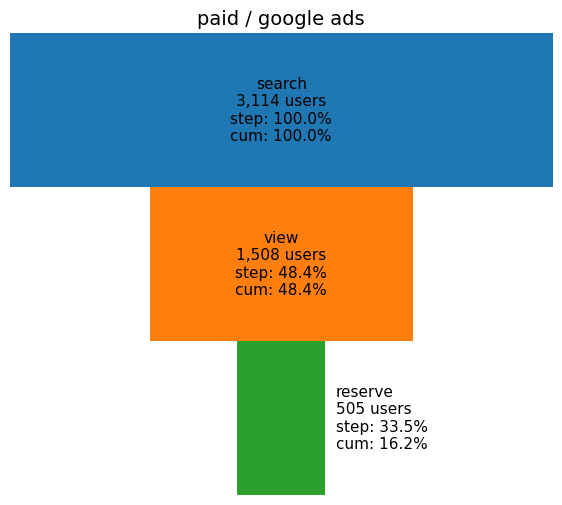

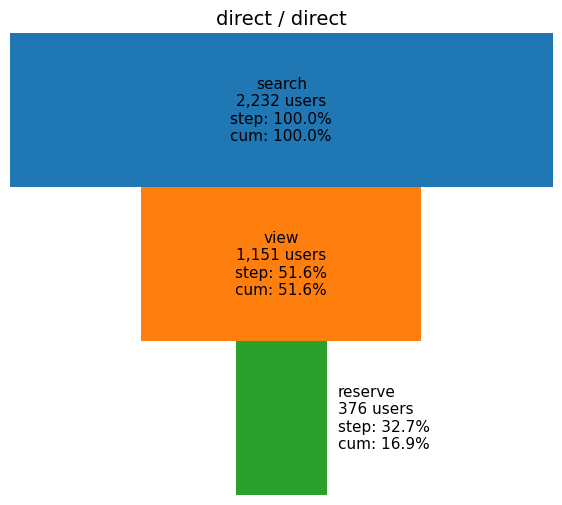

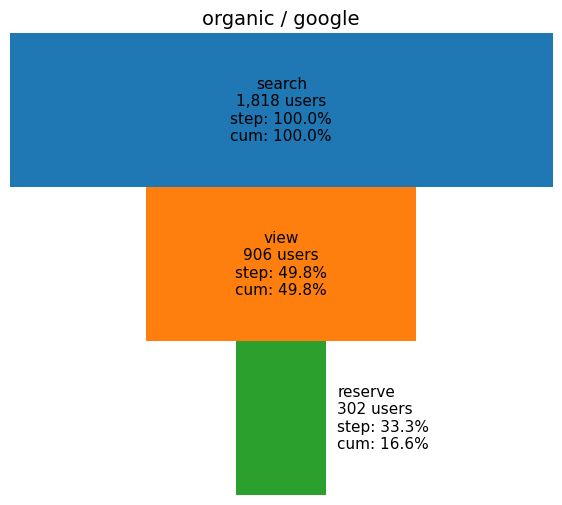

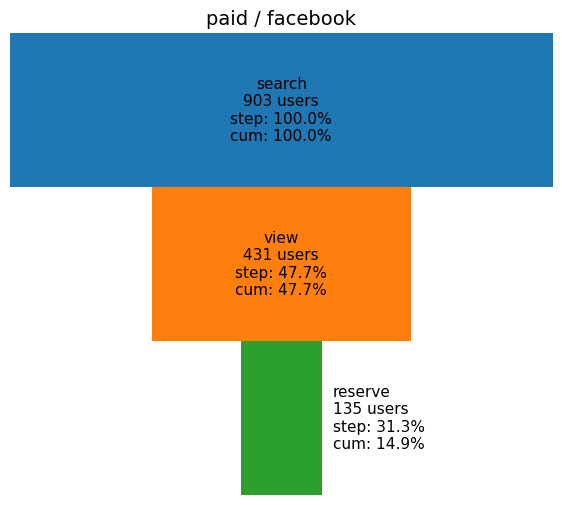

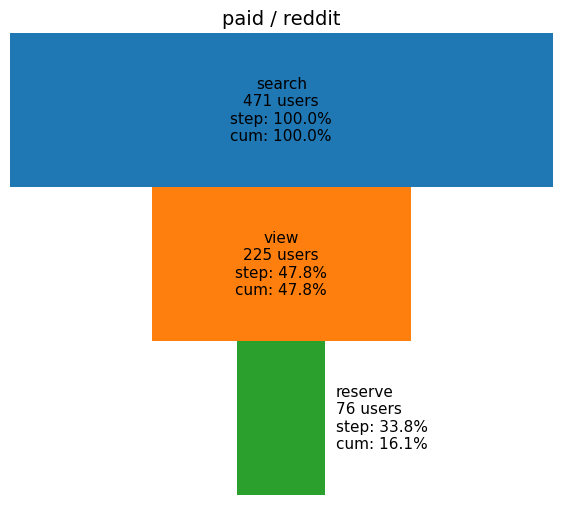

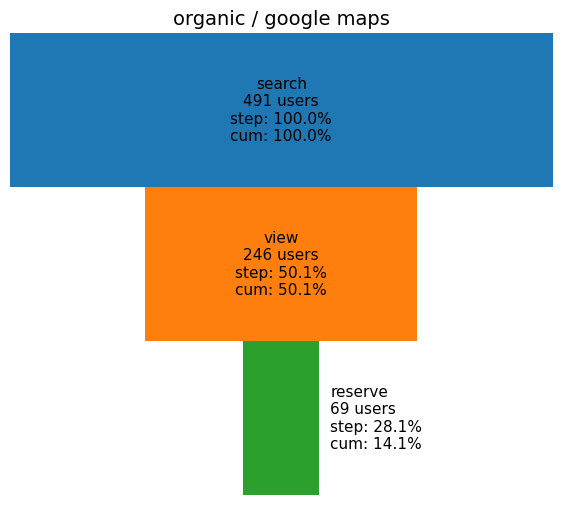

In [66]:
def _make_group_funnel_df(row: pd.Series) -> pd.DataFrame:
    return pd.DataFrame({
        "stage": ["search", "view", "reserve"],
        "users": [row["search_users"], row["view_users"], row["reserve_users"]],

        "step_conversion_pct": [100.0, row["search_to_view_pct"], row["view_to_reserve_pct"]],

        "cumulative_from_search_pct": [100.0, row["search_to_view_pct"], row["search_to_reserve_pct"]],
    })

def plot_top_funnels_by_src_channel(
    funnel_by_src_channel: pd.DataFrame,
    top_n: int = 9,
    min_search_users: int = 50
):
    df = funnel_by_src_channel.copy()
    df["first_attribution_source"]  = df["first_attribution_source"].fillna("unknown")
    df["first_attribution_channel"] = df["first_attribution_channel"].fillna("unknown")


    df = df.sort_values(
        by=["reserve_users", "search_to_reserve_pct"],
        ascending=[False, False]
    )
    df = df[df["search_users"] >= min_search_users].head(top_n)

    for _, row in df.iterrows():
        fdf = _make_group_funnel_df(row)
        title = f"{row['first_attribution_source']} / {row['first_attribution_channel']}"
        plot_funnel_area_topdown_with_pcts(
            fdf,
            title=title,
            pct_label="both" #"step", "cumulative", or "both"
        )

plot_top_funnels_by_src_channel(funnel_by_src_channel, top_n=9, min_search_users=50)

In [56]:
RES_MONTH_NUM = "month(CAST(r1.created_at AS TIMESTAMP))"

funnel_by_month = sql(f"""
WITH searchers AS (
  SELECT DISTINCT
    a1.user_id,
    a1.merged_amplitude_id,
    as1.month AS month
  FROM amplitude_user_ids_1 a1
  JOIN all_search_events_1 as1
    ON a1.merged_amplitude_id = as1.merged_amplitude_id
  WHERE a1.user_id IS NOT NULL
),
viewers AS (
  SELECT DISTINCT
    s.user_id,
    s.month
  FROM view_listing_detail_events_1 vl1
  JOIN searchers s
    ON s.merged_amplitude_id = vl1.merged_amplitude_id
   AND vl1.month = s.month
),
reservers AS (
  SELECT DISTINCT
    r1.renter_user_id AS user_id,
    s.month
  FROM reservations_1 r1
  JOIN searchers s
    ON s.user_id = r1.renter_user_id
  WHERE {RES_MONTH_NUM} = s.month
),
counts AS (
  SELECT
    month,
    COUNT(DISTINCT user_id) FILTER (WHERE stage = 'search')  AS search_users,
    COUNT(DISTINCT user_id) FILTER (WHERE stage = 'view')    AS view_users,
    COUNT(DISTINCT user_id) FILTER (WHERE stage = 'reserve') AS reserve_users
  FROM (
    SELECT month, user_id, 'search'  AS stage FROM searchers
    UNION ALL
    SELECT month, user_id, 'view'    AS stage FROM viewers
    UNION ALL
    SELECT month, user_id, 'reserve' AS stage FROM reservers
  )
  GROUP BY month
)
SELECT
  month,
  search_users,
  view_users,
  reserve_users,
  ROUND(100.0 * view_users    / NULLIF(search_users, 0), 2) AS search_to_view_pct,
  ROUND(100.0 * reserve_users / NULLIF(view_users, 0), 2)   AS view_to_reserve_pct,
  ROUND(100.0 * reserve_users / NULLIF(search_users, 0), 2) AS search_to_reserve_pct
FROM counts
ORDER BY month
""")

display(funnel_by_month)

,month,search_users,view_users,reserve_users,search_to_view_pct,view_to_reserve_pct,search_to_reserve_pct
0,1,5916,2854,864,48.24,30.27,14.60
1,2,5645,2697,830,47.78,30.77,14.70
2,3,5874,2881,828,49.05,28.74,14.10
3,4,5839,2796,840,47.88,30.04,14.39
4,5,5953,2912,883,48.92,30.32,14.83
5,6,5873,2814,861,47.91,30.60,14.66
6,7,5982,2909,902,48.63,31.01,15.08
7,8,5929,2816,847,47.50,30.08,14.29
8,9,5820,2810,832,48.28,29.61,14.30
9,10,5857,2778,835,47.43,30.06,14.26


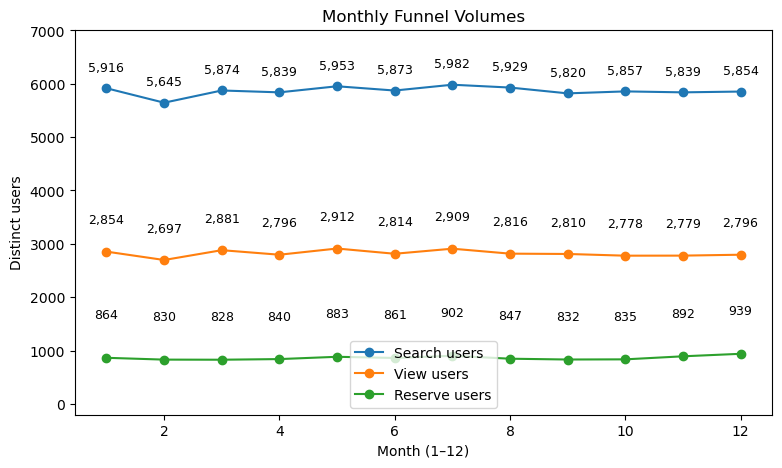

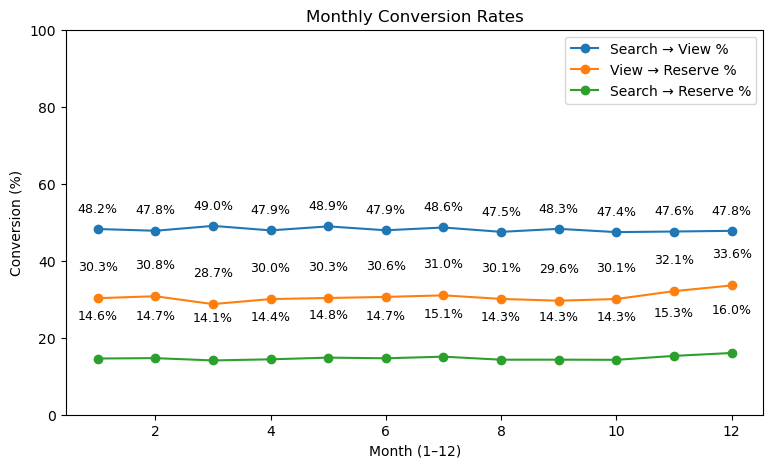

In [70]:
def _prep_month_axis(df: pd.DataFrame):
    mdf = df.copy()
    if np.issubdtype(mdf["month"].dtype, np.number):
        mdf = mdf.sort_values("month")
        return mdf["month"], "Month (1–12)", mdf
    try:
        mdf["_month_dt"] = pd.to_datetime(mdf["month"], errors="coerce")
        mdf = mdf.sort_values("_month_dt")
        return mdf["_month_dt"], "Month", mdf
    except Exception:
        mdf = mdf.sort_values("month")
        return mdf["month"], "Month", mdf

def _annotate_series(ax, x, y, fmt="int", yoffset=8):
    for xv, yv in zip(x, y):
        if pd.isna(yv):
            continue
        if fmt == "int":
            label = f"{int(yv):,}"
        elif fmt == "pct":
            label = f"{float(yv):.1f}%"
        else:
            label = str(yv)
        ax.annotate(
            label, xy=(xv, yv),
            xytext=(0, yoffset), textcoords="offset points",
            ha="center", va="bottom", fontsize=9, clip_on=True
        )

def plot_monthly_counts(funnel_by_month: pd.DataFrame, title="Monthly Funnel Volumes"):
    x, xlabel, mdf = _prep_month_axis(funnel_by_month)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(x, mdf["search_users"],  marker="o", label="Search users")
    ax.plot(x, mdf["view_users"],    marker="o", label="View users")
    ax.plot(x, mdf["reserve_users"], marker="o", label="Reserve users")

    _annotate_series(ax, x, mdf["search_users"],  fmt="int", yoffset=10)
    _annotate_series(ax, x, mdf["view_users"],    fmt="int", yoffset=18)
    _annotate_series(ax, x, mdf["reserve_users"], fmt="int", yoffset=26)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Distinct users")
    ax.legend()
    ax.margins(y=0.20)  
    if np.issubdtype(np.array(x).dtype, np.datetime64):
        fig.autofmt_xdate()
    plt.show()

def plot_monthly_conversion(funnel_by_month: pd.DataFrame, title="Monthly Conversion Rates"):
    x, xlabel, mdf = _prep_month_axis(funnel_by_month)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(x, mdf["search_to_view_pct"],    marker="o", label="Search → View %")
    ax.plot(x, mdf["view_to_reserve_pct"],   marker="o", label="View → Reserve %")
    ax.plot(x, mdf["search_to_reserve_pct"], marker="o", label="Search → Reserve %")

    _annotate_series(ax, x, mdf["search_to_view_pct"],    fmt="pct", yoffset=10)
    _annotate_series(ax, x, mdf["view_to_reserve_pct"],   fmt="pct", yoffset=18)
    _annotate_series(ax, x, mdf["search_to_reserve_pct"], fmt="pct", yoffset=26)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Conversion (%)")
    ax.set_ylim(0, 100)
    ax.legend()
    ax.margins(y=0.20)
    if np.issubdtype(np.array(x).dtype, np.datetime64):
        fig.autofmt_xdate()
    plt.show()

plot_monthly_counts(funnel_by_month)
plot_monthly_conversion(funnel_by_month)

In [ ]:
"""
RECOMMENDATIONS

1. There needs to be a renewed focus in increasing the conversion rates from the initial search to the view stage. We are losing over 50% of the traffic from this one step.
    A recommendation would be to look at those searches that come from the search_type = map first since it is the largest bucket and ends with the lowest conversion rate.

2. For another focus area, the business should look to improve their google presence and search results. Specifically, it is the Organic/Google group that we would start with first.
    From the data, I see that this group is strong in converting users to reservations and does not require as much capital to improve.
    The other area that is the largest in initial volume is Paid/Google Ads. We see that we have a decent conversion rate as compared to the other groups but with it being the largest bucket, we are losing the most potential here.

3. The final recommendation would be to get more data about the overall conversion process. Having an overall conversion of ~16% doesn't look to be sustainable over time.
    I would like to see more data on where people fall off in this process and what users experience going from the view to reserving process. If we can improve that process, we have a higher liklihood of converting more users to paying customers.

"""